## Positional Encoding

If you have paid attention in the last notebook (pun intended ;), the attention block actually does not care about the relative positions of the words in the sentences! The scores between two words is the same, no matter whether they are next to each other or far apart from each other! In other models like RNN we can feed in the words sequentially. With convolutions, the relative neighbourhood of a word is taken into account. In both models, the order is automatically taken into account.

Does order matter?

Consider these sentences again:
- The river bank is located at the next long curve.
- The next bank is located at the long river curve.

Depending on the location of the word bank in the sentence, the meaning of the word completely changes. Our model however wouldn't be able to tell them apart. To solve this issue, we can add a positional encoding. Think of it as bias, that we add to our embeddings. 

## (Optional) Mount folder in Colab

Uncomment the following cell to mount your gdrive if you are using the notebook in google colab:

In [238]:
# Use the following lines if you want to use Google Colab
# We presume you created a folder "i2dl" within your main drive folder, and put the exercise there.
# NOTE: terminate all other colab sessions that use GPU!
# NOTE 2: Make sure the correct exercise folder (e.g exercise_11) is given.

"""
from google.colab import drive
import os

gdrive_path='/content/gdrive/MyDrive/i2dl/exercise_11'

# This will mount your google drive under 'MyDrive'
drive.mount('/content/gdrive', force_remount=True)
# In order to access the files in this notebook we have to navigate to the correct folder
os.chdir(gdrive_path)
# Check manually if all files are present
print(sorted(os.listdir()))
"""

"\nfrom google.colab import drive\nimport os\n\ngdrive_path='/content/gdrive/MyDrive/i2dl/exercise_11'\n\n# This will mount your google drive under 'MyDrive'\ndrive.mount('/content/gdrive', force_remount=True)\n# In order to access the files in this notebook we have to navigate to the correct folder\nos.chdir(gdrive_path)\n# Check manually if all files are present\nprint(sorted(os.listdir()))\n"

## Setup

In [240]:
from exercise_code.util import notebook_util as util
from exercise_code.network import *
from exercise_code.tests import *
import matplotlib.pyplot as plt
import os
import numpy as np
import torch

root_path = os.path.dirname(os.path.abspath(os.getcwd()))

%load_ext autoreload
%autoreload 2

os.environ['KMP_DUPLICATE_LIB_OK']='True'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<div class="alert alert-warning">
    <h3>WARNING</h3>
    <p>The next section sort of tries to give you an intuition where the formulas for the positional encoding come from! You do not have to go through every single math equation or code line in this section, rather have a look at the graphs and try to get a feeling for what is going on! 
    </p>
</div>

### Intuition behind Positional Encoding

Suppose we use a 4d embedding and we want to encode the position of a token. A possible choice could be to simply use the binary representation of the position as an encoding. So in other words, to the token at position 5, we would add the vector [0 1 0 1]. Here are all the binary representations up to 15:


| Decimal                      | Binary                                      | Decimal                                  | Binary |
|-------------------------------------|----------------------------------------------------|--------------------------------------------------|--|
| 00 | <span style="color: green;">0</span> <span style="color: orange;">0</span> <span style="color: red;">0</span> <span style="color: cyan;">0</span> | 08 | <span style="color: green;">1</span> <span style="color: orange;">0</span> <span style="color: red;">0</span> <span style="color: cyan;">0</span> </br> |
| 01 | <span style="color: green;">0</span> <span style="color: orange;">0</span> <span style="color: red;">0</span> <span style="color: cyan;">1</span> | 09 | <span style="color: green;">1</span> <span style="color: orange;">0</span> <span style="color: red;">0</span> <span style="color: cyan;">1</span> </br> |
| 02 | <span style="color: green;">0</span> <span style="color: orange;">0</span> <span style="color: red;">1</span> <span style="color: cyan;">0</span> | 10 | <span style="color: green;">1</span> <span style="color: orange;">0</span> <span style="color: red;">1</span> <span style="color: cyan;">0</span> </br> |
| 03 | <span style="color: green;">0</span> <span style="color: orange;">0</span> <span style="color: red;">1</span> <span style="color: cyan;">1</span> | 11 | <span style="color: green;">1</span> <span style="color: orange;">0</span> <span style="color: red;">1</span> <span style="color: cyan;">1</span> </br> |
| 04 | <span style="color: green;">0</span> <span style="color: orange;">1</span> <span style="color: red;">0</span> <span style="color: cyan;">0</span> | 12 | <span style="color: green;">1</span> <span style="color: orange;">1</span> <span style="color: red;">0</span> <span style="color: cyan;">0</span> </br> |
| 05 | <span style="color: green;">0</span> <span style="color: orange;">1</span> <span style="color: red;">0</span> <span style="color: cyan;">1</span> | 13 | <span style="color: green;">1</span> <span style="color: orange;">1</span> <span style="color: red;">0</span> <span style="color: cyan;">1</span> </br> |
| 06 | <span style="color: green;">0</span> <span style="color: orange;">1</span> <span style="color: red;">1</span> <span style="color: cyan;">0</span> | 14 | <span style="color: green;">1</span> <span style="color: orange;">1</span> <span style="color: red;">1</span> <span style="color: cyan;">0</span> </br> |
| 07 | <span style="color: green;">0</span> <span style="color: orange;">1</span> <span style="color: red;">1</span> <span style="color: cyan;">1</span> | 15 | <span style="color: green;">1</span> <span style="color: orange;">1</span> <span style="color: red;">1</span> <span style="color: cyan;">1</span> </br> |

In the next plots, you will often see the term depth and position. Depth refers to embedding depth, so if we have 4 dimensional embeddings, the depth index will tell you where in the embedding to add this "bias" encoding. Position, as the name suggests, tells us where in the sentence to add this particular "bias" vector.

Let's plot this:

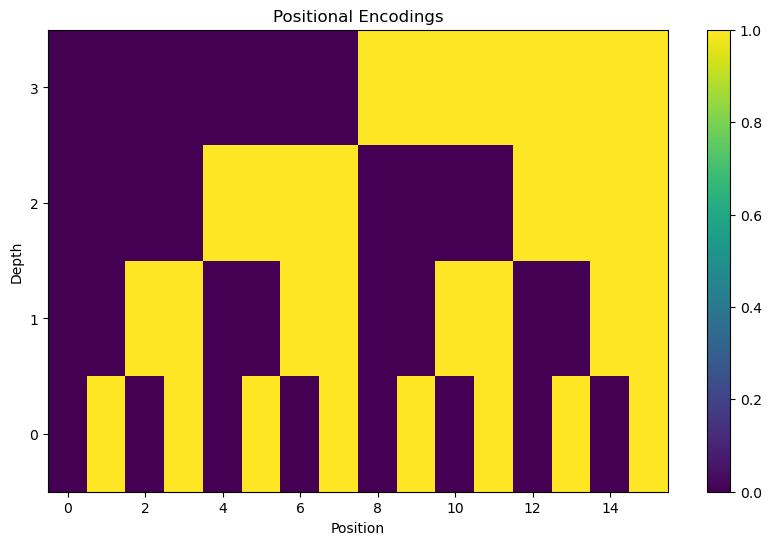

In [243]:
# We are flipping the bits around, so that the least significant bit is plotted first! This will make the formulas a little easier later!
pos_encoding = np.flip(np.array([[0, 0, 0, 0],
                                 [0, 0, 0, 1],
                                 [0, 0, 1, 0],
                                 [0, 0, 1, 1],
                                 [0, 1, 0, 0],
                                 [0, 1, 0, 1],
                                 [0, 1, 1, 0],
                                 [0, 1, 1, 1],
                                 [1, 0, 0, 0],
                                 [1, 0, 0, 1],
                                 [1, 0, 1, 0],
                                 [1, 0, 1, 1],
                                 [1, 1, 0, 0],
                                 [1, 1, 0, 1],
                                 [1, 1, 1, 0],
                                 [1, 1, 1, 1]]), axis=-1)

util.plot_positional_encoding(pos_encoding)

As you can see, every bit is jumping between 0 and 1 with a different frequency! </br>
The <span style="color: cyan;">0th bit</span> is jumping back and forth after 1 iteration. </br>
The <span style="color: red;">1st bit</span> is jumping back and forth after 2 iteration. </br>
The <span style="color: orange;">2nd bit</span> is jumping back and forth after 4 iteration. </br>
The <span style="color: green;">3rd bit</span> is jumping back and forth after 8 iteration. </br>

We can get the same pattern using a sine wave with different frequencies! In a first step, let's just have a look at the sign (+/-) of the sine function!

$ PE(pos) = \begin{bmatrix}
           -sin(\frac{\pi}{1} \cdot (pos + 0.5)) > 0 \\
           -sin(\frac{\pi}{2} \cdot (pos + 0.5)) > 0 \\
           -sin(\frac{\pi}{4} \cdot (pos + 0.5)) > 0 \\
           -sin(\frac{\pi}{8} \cdot (pos + 0.5)) > 0
         \end{bmatrix} $
         
 You might be surprised to see the negative sine here! This only because we wanted it to start negative (=0) for the first half and then become positive (=1) in the second half to match our bit pattern! Also, the pos + 0.5 might be a bit weird at first, but we only did this to compute the value of the sine wave in the middle of each cell! But it is not important, just have a look at the plot of this function:

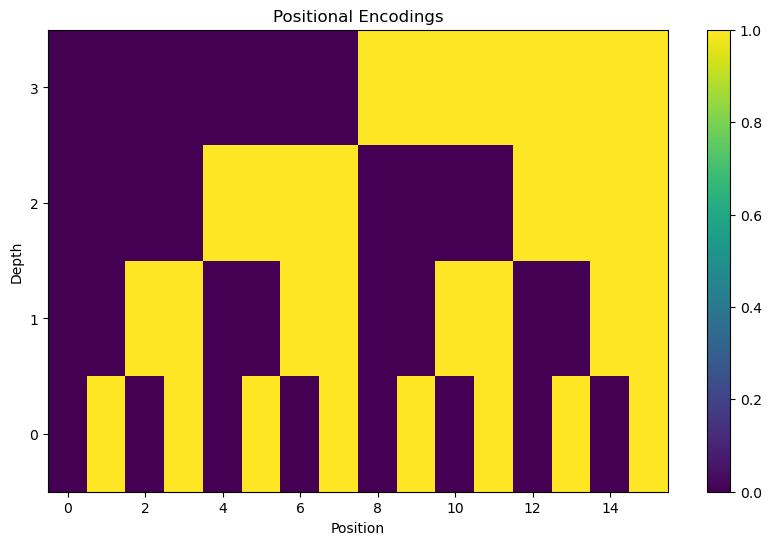

In [246]:
def positional_encoding_discrete(pos):
    return np.array([-np.sin((np.pi / 1) * (pos + 0.5)) > 0,        
                     -np.sin((np.pi / 2) * (pos + 0.5)) > 0,
                     -np.sin((np.pi / 4) * (pos + 0.5)) > 0,
                     -np.sin((np.pi / 8) * (pos + 0.5)) > 0]).T

positions = np.arange(0, 16)

util.plot_positional_encoding(positional_encoding_discrete, 
                              positions=positions)

Tadaaaa - Same pattern!

Now instead of using only the integers 0 and 1, let's use all values between 0 and 1! We will keep the rest the same for now! (That means we get rid of the sign() function, or the > 0 in code!)

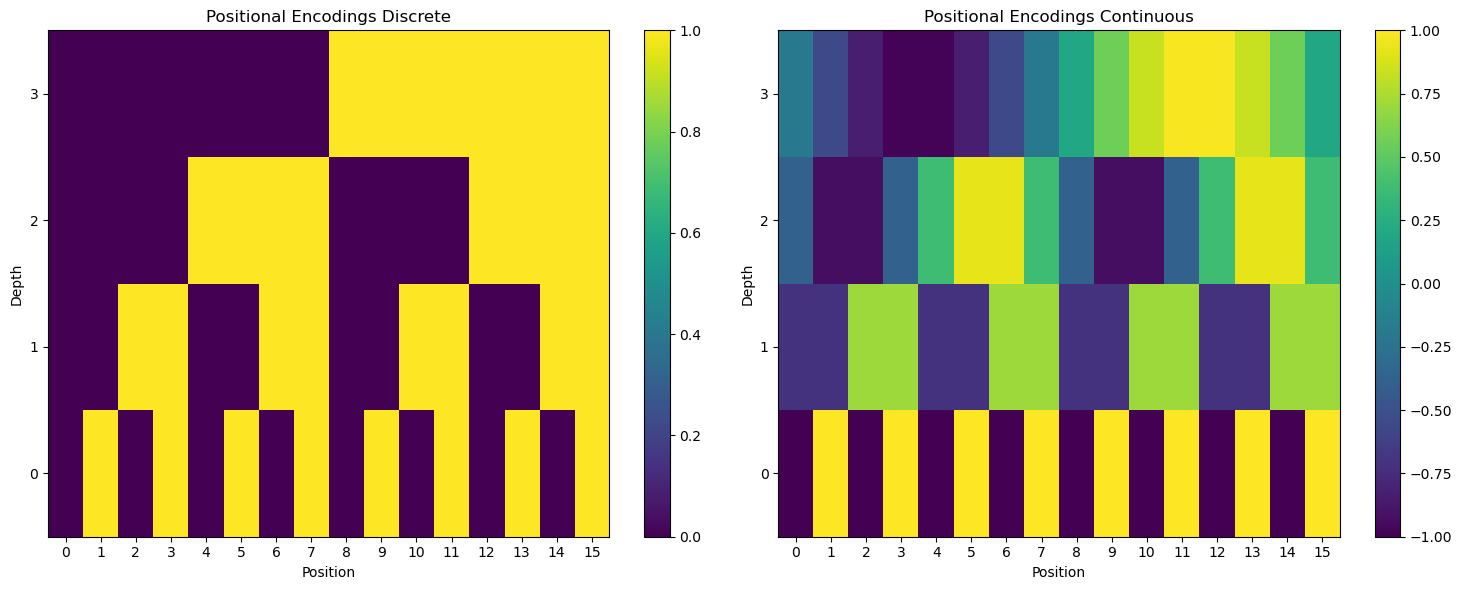

In [248]:
def positional_encoding_continuous(pos):
    return np.array([-np.sin((np.pi / 1) * (pos + 0.5)),    
                     -np.sin((np.pi / 2) * (pos + 0.5)),
                     -np.sin((np.pi / 4) * (pos + 0.5)),
                     -np.sin((np.pi / 8) * (pos + 0.5))]).T

positions = np.arange(0, 16)

util.plot_positional_encoding(positional_encoding_continuous, 
                              positional_encoding_discrete, 
                              positions=positions)

You should still sort of be able to see the original pattern, its just a bit blurred now!

From here, we are going to do a couple alterations to the formula: First of all, get rid of the pos + 0.5! That really was only there, to show the similarity to the bit pattern!

$ PE(pos) = \begin{bmatrix}
           sin(\frac{\pi}{1} \cdot pos) \\
           sin(\frac{\pi}{2} \cdot pos) \\
           sin(\frac{\pi}{4} \cdot pos) \\
           sin(\frac{\pi}{8} \cdot pos)
         \end{bmatrix} $

In a next step, we will also get rid of scaling frequency by $\pi$! This leads us to:
 
$ PE(pos) = \begin{bmatrix}
           sin(\frac{1}{1} \cdot pos) \\
           sin(\frac{1}{2} \cdot pos) \\
           sin(\frac{1}{4} \cdot pos) \\
           sin(\frac{1}{8} \cdot pos)
         \end{bmatrix} $
         
Let's have a closer look at these angle frequencies:

$\omega_0 = \frac{1}{1} =  \frac{1}{2}^0 $ \
$\omega_1 = \frac{1}{2} =  \frac{1}{2}^1 $ \
$\omega_2 = \frac{1}{4} =  \frac{1}{2}^2 $ \
$\omega_3 = \frac{1}{8} =  \frac{1}{2}^3 $ 

The frequencies form a geometric series with base $\frac{1}{2}$! Writing this as a formula with base b we get:

$\omega_i = b^i$

Now one last change we are going to do is to add a factor d in to the exponent as follows:

$\omega_i = b^{i/d}$

Remeber - i here denotes the i-th dimension of our positional encoding vector! Each Dimension "vibrates" at a it's own frequency!

This results in the follwing formula:

$ PE(pos, i) = sin(b^{i/d} \cdot pos)$

Let's have a look at the final outcome for different d's! (This will sort of look like we are zooming!)

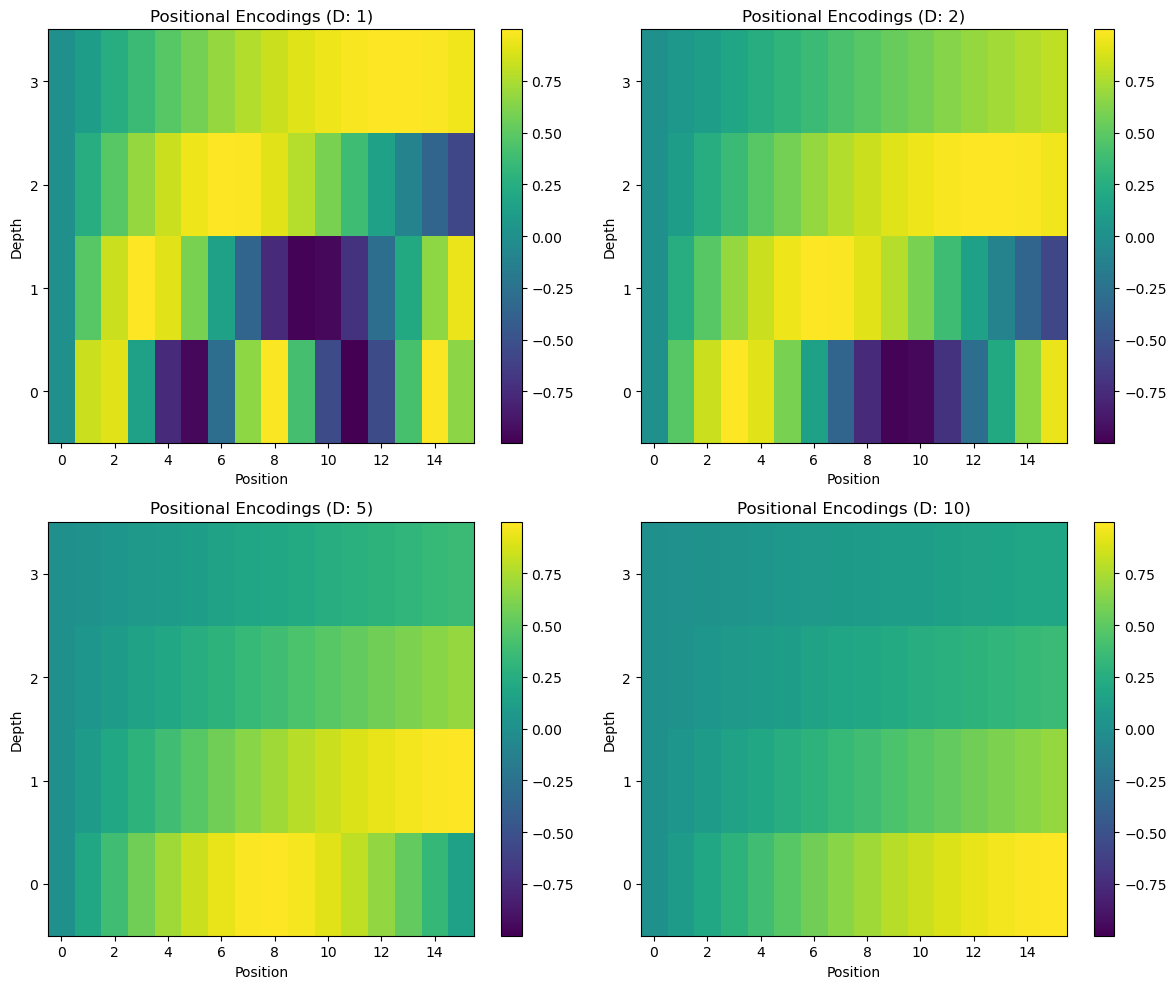

In [251]:
def positional_encoding(pos, base, d):
    return np.array([np.sin(base ** 0/d * pos),    
                     np.sin(base ** 1/d * pos),
                     np.sin(base ** 2/d * pos),
                     np.sin(base ** 3/d * pos)]).T

positions = np.arange(0, 16)

d_factors = [1, 2, 5, 10]  # Different zoom factors for the plots

util.plot_positional_encoding(positional_encoding, 
                              positions=positions, 
                              d_factors=d_factors)

Puh, that was a lot! Now with all this prep, the actual formulas shouldn't come as that big of a surprise anymore!

### Implementing Positional Encodings

The positional encodings used in the paper are actually very similar

$PE(pos, 2i) = \sin(pos / 10000 ^{2i/d})$ \
$PE(pos, 2i+1) = \cos(pos / 10000 ^{2i/d})$

At a first glance, there is a lot going on here! Rewriting the formula actually helps a lot!

$ PE(pos) = \begin{bmatrix}
           sin(w_0 \cdot pos) \\
           cos(w_0 \cdot pos) \\
           sin(w_1 \cdot pos) \\
           cos(w_1 \cdot pos) \\
           \vdots \\
           sin(w_{d/2} \cdot pos) \\
           cos(w_{d/2} \cdot pos)
         \end{bmatrix} $

With:
$ \omega_i = \frac{1}{10000}^{2i/d} $ 

Where

$pos$ refers to the position of the token in the sequence </br>
$d$ refers to the dimension of the embedding (=d_model)

Instead of only using sine functions, they also used cosine functions at every other index (note: because of this, you should always use an even embedding dimension!) </br>
In the original formula, the "every other index" is noted by $2i$ and $2i+1$, which basically means all even indices get sine functions and all uneven cosine! 

Some of you might be curious, why they added the cosine function!

To quote the paper:

> We chose this function because we hypothesized it would allow the model to easily learn to attend by relative positions, since for any fixed offset k, PE(pos+k) can be represented as a linear function of PE(pos).

Without the cosine function, this cannot be done anymore!

Anyway, let's have a look at this positional encoding! Since this encoding doesn't depend on data and is constant over training, we can compute it one time and store it as a large tensor as follows:

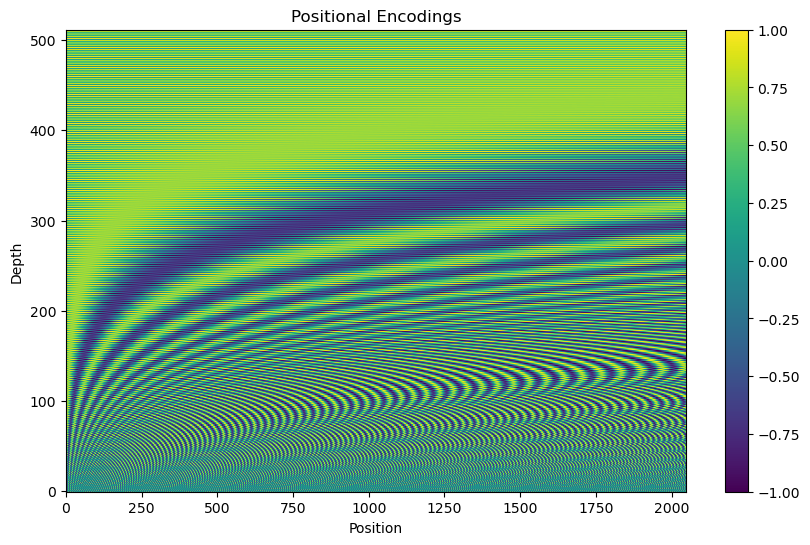

In [256]:
def positional_encoding(length, depth):

    exponent = np.arange(0, depth, 2) / depth           # Exponent for the positional encoding
    pos = np.arange(0, length)[:, None]                 # Add new axis for broadcasting

    angle_freq = np.exp(exponent * (-np.log(10000)))    # For numerical reasons - same as (1/10000) ** (exponent)
    
    pos_encoding = np.zeros((length, depth))            # Initialize the positional encoding
    
    pos_encoding[:, 0::2] = np.sin(pos * angle_freq)    # Take the sine of the even indices
    pos_encoding[:, 1::2] = np.cos(pos * angle_freq)    # Take the cosine of the odd indices

    return pos_encoding

util.plot_positional_encoding(positional_encoding,
                              length=2048, 
                              depth=512)

The version I imagine you are probably more familiar with is the following: 

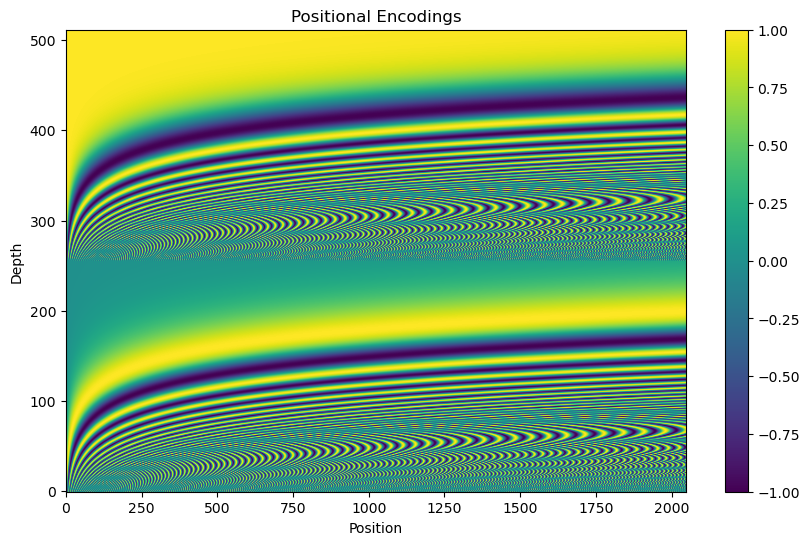

In [258]:
def positional_encoding(length, depth):

    i = np.arange(0, depth, 2) / depth
    pos = np.arange(0, length)[:, None]

    angle_freq = np.exp(i * (-np.log(10000)))

    pos_encoding = np.concatenate([np.sin(pos * angle_freq), np.cos(pos * angle_freq)], axis=-1)

    return pos_encoding

util.plot_positional_encoding(positional_encoding,
                              length=2048, 
                              depth=512)

The only difference is that instead of using sine for the even and cosine for the uneven we just concatenate the two vectors. Both versions are valid, since the main thing we want to achieve with this encoding is that vectors close by have a higher score and vectors further apart have a lower score. 

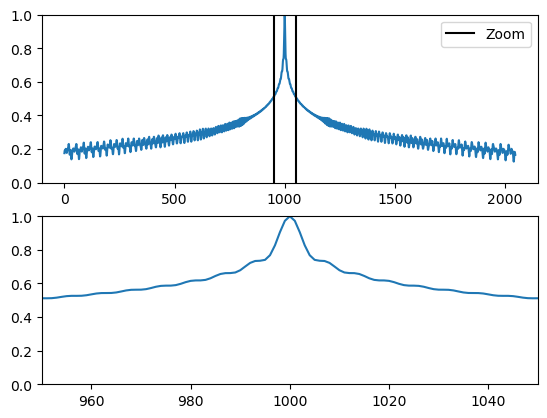

In [260]:
pos_encoding = positional_encoding(length=2048, depth=512)
pos_encoding = pos_encoding / np.linalg.norm(pos_encoding, axis=-1, keepdims=True)

p = pos_encoding[1000]
scores = pos_encoding @ p

util.plot_scores(scores)

<div class="alert alert-info">
    <h3>Task 4: Implement</h3>
    <p>Implement the positional encoding method and initialize it in the <code>Embedding</code> class in <code>exercise_code/network/embedding.py</code>.
    </p>
</div>

In [262]:
_ = test_task_4()


####### Testing Started #######

Test PositionalEncodingValueTest: failed --> Positional Encoding wasn't implemented correctly!.
Test EmbeddingForwardShapeTest: passed!
Test EmbeddingValueTest: passed!

####### Testing Finished #######
Test TestTask4: failed -->  Tests passed: 2/3
Score: 66/100


Congrats! You've now finished your first transformer model! Since this is a totally new exercise, we would really appreciate it if you could give us some [feedback](https://forms.gle/7dS4QAvVTJat9LBw8)! Like which explanations did you like or not like, what was to hard and maybe what was to easy! 

To create a zip file with your submission, run the following cell:

In [264]:
from exercise_code.util.submit import submit_exercise

path = os.path.join(root_path, 'output', 'exercise11')
submit_exercise(path)

relevant folders: ['exercise_code']
notebooks files: ['1_tokenizer.ipynb', '2_embedding.ipynb', '3_attention.ipynb', '4_positional_encoding.ipynb']
Adding folder exercise_code
Adding notebook 1_tokenizer.ipynb
Adding notebook 2_embedding.ipynb
Adding notebook 3_attention.ipynb
Adding notebook 4_positional_encoding.ipynb
Zipping successful! Zip is stored under: D:\jupyter_project\output\exercise11.zip


# Submission Instructions

To complete the exercise, submit your final model to our submission portal - you probably know the procedure by now.

1. Go on [our submission page](https://i2dl.cvg.cit.tum.de/submission/), register for an account and login. We use your matriculation number and send an email with the login details to the mail account associated. When in doubt, login into tum online and check your mails there. You will get an ID which we need in the next step.
2. Log into [our submission page](https://i2dl.cvg.cit.tum.de/submission/) with your account details and upload the `zip` file. Once successfully uploaded, you should be able to see the submitted file selectable on the top.
3. Click on this file and run the submission script. You will get an email with your score as well as a message if you have surpassed the threshold.

# Submission Goals

- Goal: Successfully implement the attention mechanism!

- Points:
    - 5 points per Module if shape is correct (Embedding, Positional Encoding, Scaled Dot Attention, Multi-Head Attention)
    - 5 points per Module if output is correct (Embedding, Positional Encoding, Scaled Dot Attention, Multi-Head Attention)
    - Total = 4 x 5 + 4 x 5 = 40

- Passing Criteria: Minimum of 35 points!
- Feel free to submit an unlimited number of assignments until the end of the semester; however, any submissions made after the deadline will not contribute to your bonus points.
 